In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
import seaborn as sb
import scipy
import time
from imblearn.over_sampling import SMOTE
import sklearn.gaussian_process as gp
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import lightgbm as lgb
import forestci

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:47: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
Failed to import duecredit due to No module named 'duecredit'


In [2]:
import tensorflow as tf

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
os.listdir('dataset')

['application_test.csv',
 'HomeCredit_columns_description.csv',
 'POS_CASH_balance.csv',
 'credit_card_balance.csv',
 'installments_payments.csv',
 'application_train.csv',
 'bureau.csv',
 'previous_application.csv',
 'bureau_balance.csv',
 'sample_submission.csv']

In [4]:
dataset_test = pd.read_csv('dataset/application_test.csv')
dataset_train = pd.read_csv('dataset/application_train.csv')

In [5]:
dataset_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
dataset_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

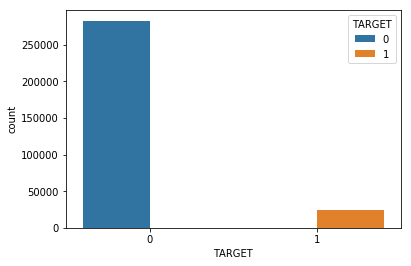

In [7]:
sb.countplot(x='TARGET',hue='TARGET',data=dataset_train)

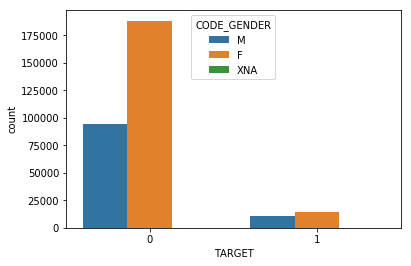

In [8]:
sb.countplot(x='TARGET',hue='CODE_GENDER',data=dataset_train)

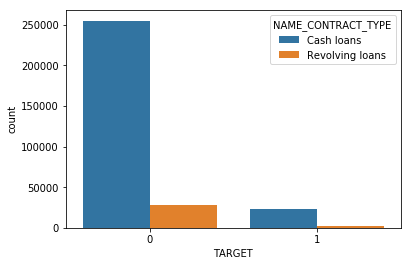

In [9]:
sb.countplot(x='TARGET',hue='NAME_CONTRACT_TYPE',data=dataset_train)

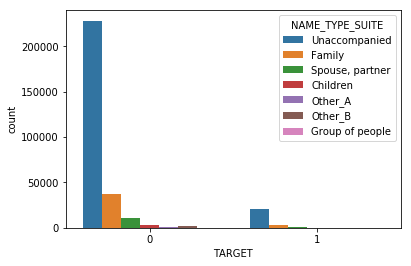

In [10]:
sb.countplot(x='TARGET',hue='NAME_TYPE_SUITE',data=dataset_train)

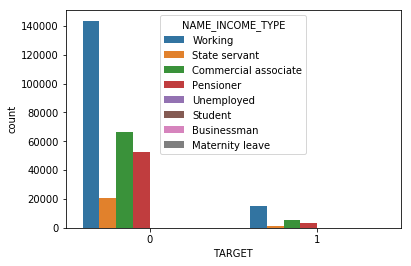

In [11]:
sb.countplot(x='TARGET',hue='NAME_INCOME_TYPE',data=dataset_train)

In [12]:
(dataset_train['DAYS_BIRTH']/-365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

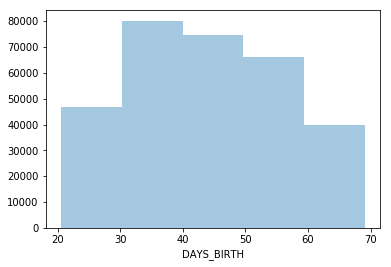

In [13]:
sb.distplot(dataset_train['DAYS_BIRTH']/-365,bins=5,kde=False)

In [14]:
len(dataset_train[dataset_train['DAYS_EMPLOYED'] > 0])


55374

In [15]:
(dataset_train[dataset_train['DAYS_EMPLOYED'] > 0]['TARGET'] == 1).value_counts()

False    52384
True      2990
Name: TARGET, dtype: int64

In [16]:
(abs(dataset_train['DAYS_EMPLOYED']/365)).describe()

count    307511.000000
mean        185.547239
std         382.037676
min           0.000000
25%           2.556164
50%           6.079452
75%          15.635616
max        1000.665753
Name: DAYS_EMPLOYED, dtype: float64

In [17]:
max(dataset_train['DAYS_EMPLOYED'])

365243

In [18]:
len(dataset_train['DAYS_EMPLOYED'] == 365243)

307511

In [19]:
dataset_train['EMP_AN'] = dataset_train['DAYS_EMPLOYED'] == 365243

In [20]:
dataset_train['DAYS_EMPLOYED'] = dataset_train['DAYS_EMPLOYED'].replace({365243: np.nan})

In [21]:
(abs(dataset_train['DAYS_EMPLOYED']/365)).describe()

count    252137.000000
mean          6.531971
std           6.406466
min           0.000000
25%           2.101370
50%           4.515068
75%           8.698630
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

In [22]:
(abs(dataset_train['DAYS_REGISTRATION']/365)).describe()

count    307511.000000
mean         13.660604
std           9.651743
min           0.000000
25%           5.506849
50%          12.339726
75%          20.491781
max          67.594521
Name: DAYS_REGISTRATION, dtype: float64

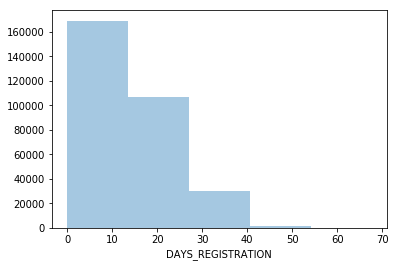

In [23]:
sb.distplot(dataset_train['DAYS_REGISTRATION']/-365,bins=5,kde=False)

In [24]:
len(dataset_train[dataset_train['DAYS_REGISTRATION']/-365 > 50]['DAYS_BIRTH']/-365 > 50)

80

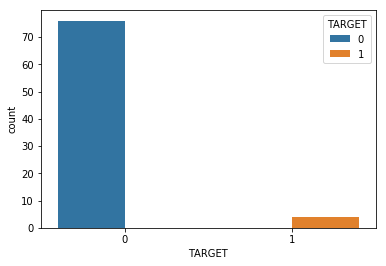

In [25]:
sb.countplot(x='TARGET',hue='TARGET',data=dataset_train[dataset_train['DAYS_REGISTRATION']/-365 > 50])

In [26]:
dataset_train = dataset_train.drop(dataset_train[dataset_train['DAYS_REGISTRATION']/-365 > 50].index,axis=0)

In [27]:
len(dataset_train[dataset_train['DAYS_REGISTRATION']/-365 > 50]['DAYS_BIRTH']/-365 > 50)

0

In [28]:
dataset_train.shape

(307431, 123)

In [29]:
corr = dataset_train.corr(method='pearson')

In [30]:
column_names = list(corr.columns.values)
columns_to_remove = []
for idx,row in corr.iterrows():
    for i in range(0,len(row)):
        if row[i] > 0.70:
            if idx != column_names[i] and idx not in columns_to_remove and column_names[i] not in columns_to_remove:
                columns_to_remove.append(idx)
                columns_to_remove.append(column_names[i])
                print(idx + " - " + column_names[i])
                print(row[i])

CNT_CHILDREN - CNT_FAM_MEMBERS
0.8791849055884082
AMT_CREDIT - AMT_ANNUITY
0.7701355325112837
REGION_RATING_CLIENT - REGION_RATING_CLIENT_W_CITY
0.9508244177203856
REG_REGION_NOT_WORK_REGION - LIVE_REGION_NOT_WORK_REGION
0.8606542659268078
REG_CITY_NOT_WORK_CITY - LIVE_CITY_NOT_WORK_CITY
0.8255558750839367
APARTMENTS_AVG - ELEVATORS_AVG
0.8369526900299763
BASEMENTAREA_AVG - BASEMENTAREA_MODE
0.973496185301789
YEARS_BEGINEXPLUATATION_AVG - YEARS_BEGINEXPLUATATION_MODE
0.97189305389083
YEARS_BUILD_AVG - YEARS_BUILD_MODE
0.9894360514168624
COMMONAREA_AVG - COMMONAREA_MODE
0.9771461116759385
ENTRANCES_AVG - ENTRANCES_MODE
0.9777417653401914
FLOORSMAX_AVG - FLOORSMIN_AVG
0.7424268126795673
LANDAREA_AVG - LANDAREA_MODE
0.9736925929909296
LIVINGAPARTMENTS_AVG - LIVINGAREA_AVG
0.8807913124080583
NONLIVINGAPARTMENTS_AVG - NONLIVINGAPARTMENTS_MODE
0.9693697425066614
NONLIVINGAREA_AVG - NONLIVINGAREA_MODE
0.9660854607189583
APARTMENTS_MODE - ELEVATORS_MODE
0.8262109330460732
FLOORSMAX_MODE - FLOO

In [31]:
#Columnd to remove die to high correlation (Only measured colinearity among pairs of parameters still have to deal
#with multi-colinearity)
columns_to_remove = ['CNT_CHILDREN','REGION_RATING_CLIENT_W_CITY','REG_REGION_NOT_WORK_REGION',
                    'LIVE_CITY_NOT_WORK_CITY','ELEVATORS_AVG','BASEMENTAREA_MODE','YEARS_BEGINEXPLUATATION_MODE',
                    'YEARS_BUILD_MODE','COMMONAREA_MODE','ENTRANCES_MODE','FLOORSMIN_AVG','LANDAREA_MODE',
                    'LIVINGAPARTMENTS_AVG','NONLIVINGAPARTMENTS_MODE','ELEVATORS_MODE','FLOORSMIN_MODE',
                    'LIVINGAREA_MODE','ELEVATORS_MEDI','FLOORSMIN_MEDI','LIVINGAREA_MEDI','OBS_60_CNT_SOCIAL_CIRCLE',
                    'DEF_60_CNT_SOCIAL_CIRCLE']

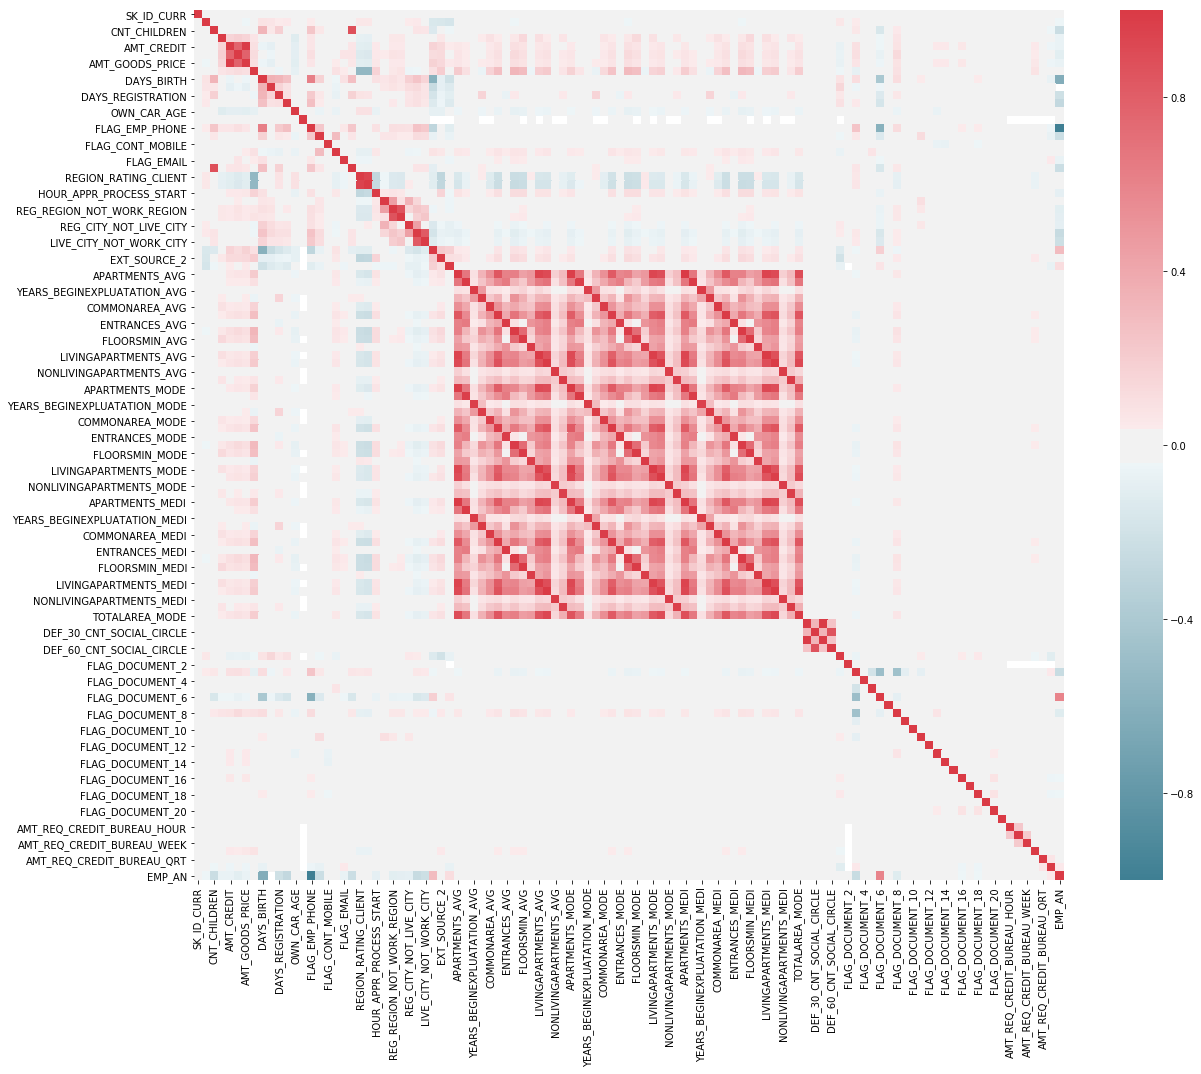

In [32]:
f,ax = plt.subplots(figsize=(20,16))
corr = dataset_train.corr()
corr_heatmap = sb.heatmap(corr,mask=np.zeros_like(corr,dtype=np.bool),cmap=sb.diverging_palette(220,10,as_cmap=True),square=True,ax=ax)
corr_figure = corr_heatmap.get_figure()
corr_figure.savefig("correlations_heatmap.png")

In [33]:
dataset_train = dataset_train.drop(columns_to_remove,axis=1)

In [34]:
dataset_train.select_dtypes('object').apply(pd.Series.nunique)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [35]:
columns_to_label_encode = ['NAME_CONTRACT_TYPE','FLAG_OWN_CAR',
                           'FLAG_OWN_REALTY','EMERGENCYSTATE_MODE']
starttime = time.time()
for column in columns_to_label_encode:
    le = LabelEncoder()
    dataset_train[column] = le.fit_transform(dataset_train[column].astype(str))
endtime = time.time()
print("Time Elapsed:- ")
print(endtime - starttime)

Time Elapsed:- 
0.2969329357147217


In [36]:
columns_to_one_hot_encode = ['CODE_GENDER','NAME_TYPE_SUITE','NAME_INCOME_TYPE',
                           'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE',
                             'OCCUPATION_TYPE','ORGANIZATION_TYPE','WEEKDAY_APPR_PROCESS_START',
                            'FONDKAPREMONT_MODE','WALLSMATERIAL_MODE','HOUSETYPE_MODE']
starttime = time.time()
for column in columns_to_one_hot_encode:
    le = LabelEncoder()
    oe = OneHotEncoder()
    label_encoded = le.fit_transform(dataset_train[column].astype(str))
    label_encoded = label_encoded.reshape(-1,1)
    one_hot_encoded = oe.fit_transform(label_encoded).toarray()
    df = pd.DataFrame(one_hot_encoded,columns=[column + str(i) for i in range(0,one_hot_encoded.shape[1])])
    df = df.drop([column + "0"],axis=1)
    dataset_train = pd.concat([dataset_train,df],axis=1)
    print(column + " - " + str(dataset_train.shape[0]) + " " + str(dataset_train.shape[1]))
dataset_train = dataset_train.drop(columns_to_one_hot_encode,axis=1)
dataset_train.shape

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


CODE_GENDER - 307511 103


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


NAME_TYPE_SUITE - 307511 110


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


NAME_INCOME_TYPE - 307511 118


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


NAME_EDUCATION_TYPE - 307511 123


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


NAME_FAMILY_STATUS - 307511 129


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


NAME_HOUSING_TYPE - 307511 135


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


OCCUPATION_TYPE - 307511 153


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


ORGANIZATION_TYPE - 307511 211


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


WEEKDAY_APPR_PROCESS_START - 307511 218


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


FONDKAPREMONT_MODE - 307511 222


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


WALLSMATERIAL_MODE - 307511 229


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


HOUSETYPE_MODE - 307511 232


(307511, 220)

In [37]:
dataset_train['DIR'] = dataset_train['AMT_CREDIT']/dataset_train['AMT_INCOME_TOTAL']
dataset_train['AIR'] = dataset_train['AMT_ANNUITY']/dataset_train['AMT_INCOME_TOTAL']
dataset_train['ACR'] = dataset_train['AMT_ANNUITY']/dataset_train['AMT_CREDIT']
dataset_train['DAR'] = dataset_train['DAYS_EMPLOYED']/dataset_train['DAYS_BIRTH']

In [38]:
#Using random under sampling to handle imbalanced dataset
under_sampled_dataset_train_0 = dataset_train[dataset_train.TARGET == 0].sample(40000)
under_sampled_dataset_train_1 = dataset_train[dataset_train.TARGET == 1].sample(20000)
dataset_train = pd.concat([under_sampled_dataset_train_0,under_sampled_dataset_train_1],ignore_index=True)

In [39]:
from sklearn.preprocessing import StandardScaler, Imputer
imputer = Imputer(strategy='median')
scaler = StandardScaler()
dataset_train_tr = imputer.fit_transform(dataset_train.drop(['SK_ID_CURR','TARGET'],axis=1))
dataset_train_tr = scaler.fit_transform(dataset_train_tr)

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [40]:
X = dataset_train_tr
y = dataset_train['TARGET']

In [41]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=232)

In [42]:
X_test = pd.DataFrame(X_test,columns=dataset_train.columns.drop(['SK_ID_CURR','TARGET']))

In [43]:
X_test.shape

(12000, 222)

In [44]:
y_test.shape

(12000,)

Text(0.5,0.98,'Benchmark Data Resampled with SMOTE')

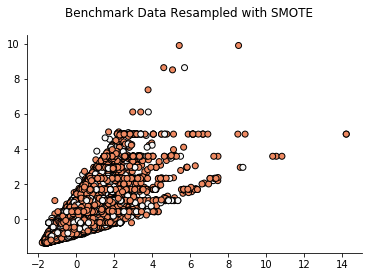

In [45]:
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_train]
kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
plt.scatter(X_train[:, 5], X_train[:, 6], c=colors, **kwarg_params)
sb.despine()
plt.suptitle("Benchmark Data Resampled with SMOTE")

In [46]:
#Using SMOTE(Synthetic Minority Oversampling Technique) to handle imbalanced dataset
smote_train = SMOTE(random_state=232)
os_data_X,os_data_y = smote_train.fit_sample(X_train,y_train)
X_train = pd.DataFrame(data=os_data_X,columns=dataset_train.columns.drop(['SK_ID_CURR','TARGET']) )
y_train = pd.DataFrame(data=os_data_y,columns=["TARGET"])

Text(0.5,0.98,'Benchmark Data Resampled with SMOTE')

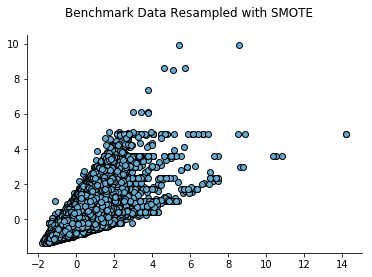

In [47]:
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_train]
kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
plt.scatter(X_train.iloc[:, 5], X_train.iloc[:, 6], c=colors, **kwarg_params)
sb.despine()
plt.suptitle("Benchmark Data Resampled with SMOTE")

In [48]:
X_test.shape

(12000, 222)

In [49]:
y_test.shape

(12000,)

Text(0.5,0.98,'Benchmark Data Resampled with SMOTE')

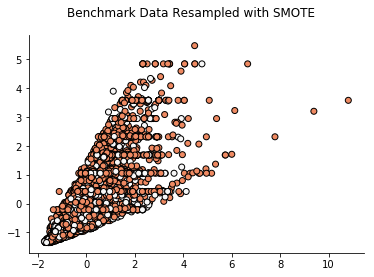

In [50]:
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_test]
kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
plt.scatter(X_test.iloc[:, 5], X_test.iloc[:, 6], c=colors, **kwarg_params)
sb.despine()
plt.suptitle("Benchmark Data Resampled with SMOTE")

In [51]:
smote_test = SMOTE(random_state=232)
os_data_X,os_data_Y = smote_test.fit_sample(X_test,y_test)
X_test = pd.DataFrame(data=os_data_X,columns=dataset_train.columns.drop(['SK_ID_CURR','TARGET']))
y_test = pd.DataFrame(data=os_data_Y,columns=['TARGET'])

Text(0.5,0.98,'Benchmark Data Resampled with SMOTE')

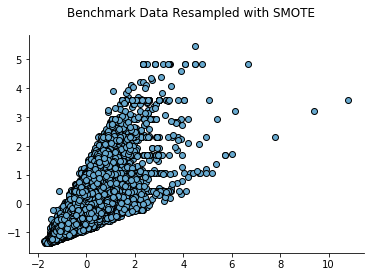

In [52]:
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_test]
kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
plt.scatter(X_test.iloc[:, 5], X_test.iloc[:, 6], c=colors, **kwarg_params)
sb.despine()
plt.suptitle("Benchmark Data Resampled with SMOTE")

In [53]:
X_train.shape

(63824, 222)

In [54]:
y_train.shape

(63824, 1)

In [55]:
X_test.shape

(16176, 222)

In [56]:
y_test.shape

(16176, 1)

In [57]:
def generate_classifier_report(classifier,predictions,predictions_prob,name):
    print(classification_report(y_test,predictions))
    logit_roc_score = roc_auc_score(y_test,predictions)
    fpr, tpr, thresholds = roc_curve(y_test,predictions_prob)
    plt.figure()
    plt.plot(fpr,tpr,label=name + " AUC score:- " + str(logit_roc_score))
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.xlabel('False Positive Rate (FP / (FP + TN))')
    plt.ylabel('True Positive Rate (TP / (TP + FN))')
    plt.title('Receiver Operating Characteristics Curve')
    plt.legend(loc="lower right")
    plt.savefig(name + "_roc_curve")
    plt.show()

In [58]:
X.shape

(60000, 222)

In [59]:
y.shape

(60000,)

In [60]:
X = pd.concat([X_train,X_test],axis=0)
y = pd.concat([y_train,y_test],axis=0)

In [61]:
y_train = np.array(y_train)
y_train = y_train.ravel()

In [62]:
y_test = np.array(y_test)
y_test = y_test.ravel()

In [63]:
y = np.array(y)
y = y.ravel()

In [64]:
def cross_validation_score(model,X,y,cv=5):
    scores = cross_val_score(model,X,y,cv=cv)
    return sum(scores)/len(scores)

In [65]:
#Use k-fold cross validation to generate estimate of test accuracy

In [66]:
clf = LogisticRegression(C=0.4,max_iter = 1000)
clf.fit(X_train,y_train)

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.4, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [67]:
prediction = clf.predict(X_test)

In [68]:
accuracy_score(y_test,prediction)

0.6992457962413452

In [69]:
confusion_matrix(y_test,prediction)

array([[5579, 2509],
       [2356, 5732]])

In [70]:
cross_validation_score(clf,X,y,cv=5)

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

0.7003375000000001

              precision    recall  f1-score   support

         0.0       0.70      0.69      0.70      8088
         1.0       0.70      0.71      0.70      8088

   micro avg       0.70      0.70      0.70     16176
   macro avg       0.70      0.70      0.70     16176
weighted avg       0.70      0.70      0.70     16176



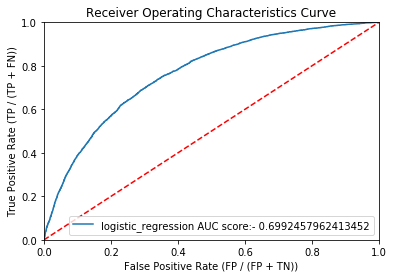

In [71]:
generate_classifier_report(clf,prediction,clf.predict_proba(X_test)[:,1],name="logistic_regression")

In [ ]:
starttime = time.time()
clf = SVC(gamma=0.001, C=1.0,probability=True,verbose=True)
clf.fit(X_train,y_train)
endtime = time.time()
print("Time to train SVC classifier:- ")
print(endtime - starttime)

[LibSVM]

In [ ]:
pred = clf.predict(X_test)
accuracy_score(y_test,pred)

In [ ]:
#Not evaluating cross_val_score because of high training time in SVC
confusion_matrix(y_test,pred).ravel()

In [ ]:
generate_classifier_report(clf,pred,clf.predict_proba(X_test)[:,1],name="svc")

In [72]:
clf = LinearDiscriminantAnalysis()
clf.fit(X_train,y_train)

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [73]:
pred = clf.predict(X_test)

In [74]:
accuracy_score(y_test,pred)

0.6994930761622157

In [75]:
cross_validation_score(clf,X,y,cv=5)

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0.6997875

              precision    recall  f1-score   support

         0.0       0.70      0.69      0.70      8088
         1.0       0.70      0.71      0.70      8088

   micro avg       0.70      0.70      0.70     16176
   macro avg       0.70      0.70      0.70     16176
weighted avg       0.70      0.70      0.70     16176



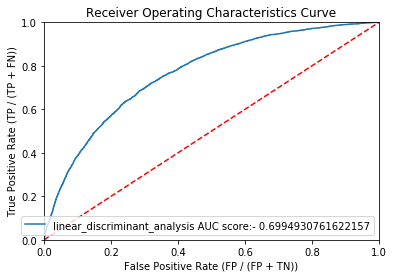

In [76]:
generate_classifier_report(clf,pred,clf.predict_proba(X_test)[:,1],name="linear_discriminant_analysis")

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Time to train 10 trees:- 
1.992955207824707
Accuracy score for 10 trees:- 
0.7430761622156281
Confusion matrix for 10 trees:- 
[6455 1633 2523 5565]
OOB score for 10 trees:- 
0.7127099523690148
Classifier report for 10 trees:- 
              precision    recall  f1-score   support

         0.0       0.72      0.80      0.76      8088
         1.0       0.77      0.69      0.73      8088

   micro avg       0.74      0.74      0.74     16176
   macro avg       0.75      0.74      0.74     16176
weighted avg       0.75      0.74      0.74     16176



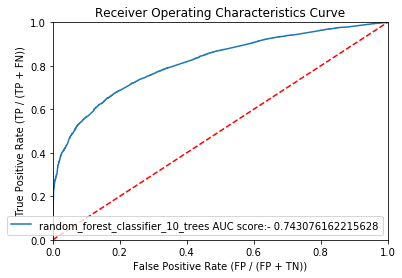

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Time to train 20 trees:- 
3.8112151622772217
Accuracy score for 20 trees:- 
0.7562438180019783
Confusion matrix for 20 trees:- 
[6560 1528 2415 5673]
OOB score for 20 trees:- 
0.7425889947355226
Classifier report for 20 trees:- 
              precision    recall  f1-score   support

         0.0       0.73      0.81      0.77      8088
         1.0       0.79      0.70      0.74      8088

   micro avg       0.76      0.76      0.76     16176
   macro avg       0.76      0.76      0.76     16176
weighted avg       0.76      0.76      0.76     16176



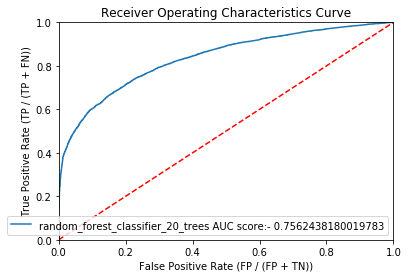

Time to train 30 trees:- 
5.656198024749756
Accuracy score for 30 trees:- 
0.7633531157270029
Confusion matrix for 30 trees:- 
[6688 1400 2428 5660]
OOB score for 30 trees:- 
0.7620487590874906
Classifier report for 30 trees:- 
              precision    recall  f1-score   support

         0.0       0.73      0.83      0.78      8088
         1.0       0.80      0.70      0.75      8088

   micro avg       0.76      0.76      0.76     16176
   macro avg       0.77      0.76      0.76     16176
weighted avg       0.77      0.76      0.76     16176



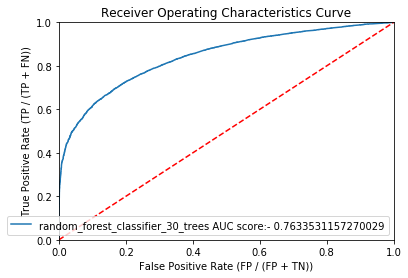

Time to train 40 trees:- 
7.410706043243408
Accuracy score for 40 trees:- 
0.7702769535113749
Confusion matrix for 40 trees:- 
[6698 1390 2326 5762]
OOB score for 40 trees:- 
0.7681123088493357
Classifier report for 40 trees:- 
              precision    recall  f1-score   support

         0.0       0.74      0.83      0.78      8088
         1.0       0.81      0.71      0.76      8088

   micro avg       0.77      0.77      0.77     16176
   macro avg       0.77      0.77      0.77     16176
weighted avg       0.77      0.77      0.77     16176



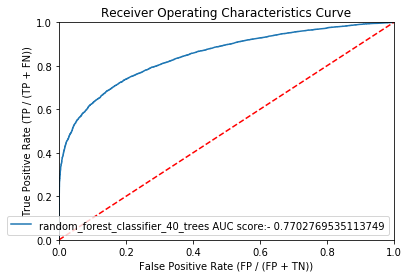

Time to train 50 trees:- 
9.184104204177856
Accuracy score for 50 trees:- 
0.7736152324431256
Confusion matrix for 50 trees:- 
[6755 1333 2329 5759]
OOB score for 50 trees:- 
0.77431687139634
Classifier report for 50 trees:- 
              precision    recall  f1-score   support

         0.0       0.74      0.84      0.79      8088
         1.0       0.81      0.71      0.76      8088

   micro avg       0.77      0.77      0.77     16176
   macro avg       0.78      0.77      0.77     16176
weighted avg       0.78      0.77      0.77     16176



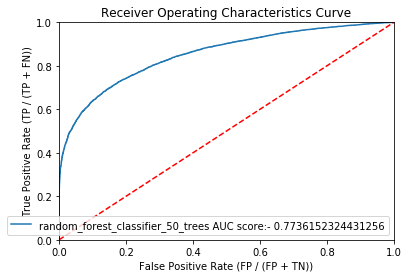

Time to train 100 trees:- 
19.539491176605225
Accuracy score for 100 trees:- 
0.7742952522255193
Confusion matrix for 100 trees:- 
[6781 1307 2344 5744]
OOB score for 100 trees:- 
0.7876347455502632
Classifier report for 100 trees:- 
              precision    recall  f1-score   support

         0.0       0.74      0.84      0.79      8088
         1.0       0.81      0.71      0.76      8088

   micro avg       0.77      0.77      0.77     16176
   macro avg       0.78      0.77      0.77     16176
weighted avg       0.78      0.77      0.77     16176



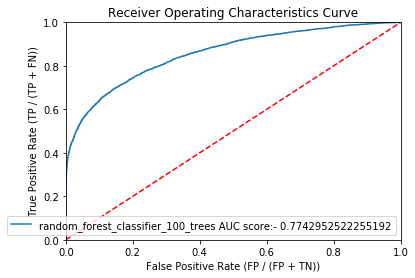

Time to train 150 trees:- 
32.55322003364563
Accuracy score for 150 trees:- 
0.7798590504451038
Confusion matrix for 150 trees:- 
[6821 1267 2294 5794]
OOB score for 150 trees:- 
0.7909407119578842
Classifier report for 150 trees:- 
              precision    recall  f1-score   support

         0.0       0.75      0.84      0.79      8088
         1.0       0.82      0.72      0.76      8088

   micro avg       0.78      0.78      0.78     16176
   macro avg       0.78      0.78      0.78     16176
weighted avg       0.78      0.78      0.78     16176



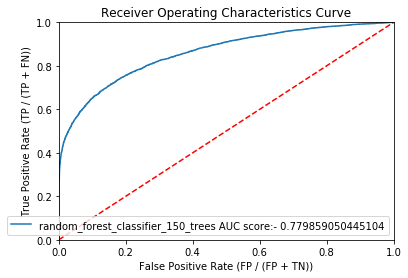

Time to train 200 trees:- 
45.02246379852295
Accuracy score for 200 trees:- 
0.7801681503461919
Confusion matrix for 200 trees:- 
[6838 1250 2306 5782]
OOB score for 200 trees:- 
0.7925075206818751
Classifier report for 200 trees:- 
              precision    recall  f1-score   support

         0.0       0.75      0.85      0.79      8088
         1.0       0.82      0.71      0.76      8088

   micro avg       0.78      0.78      0.78     16176
   macro avg       0.79      0.78      0.78     16176
weighted avg       0.79      0.78      0.78     16176



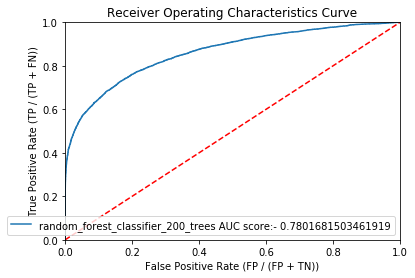

Time to train 250 trees:- 
53.17359018325806
Accuracy score for 250 trees:- 
0.7796735905044511
Confusion matrix for 250 trees:- 
[6834 1254 2310 5778]
OOB score for 250 trees:- 
0.7944346954123841
Classifier report for 250 trees:- 
              precision    recall  f1-score   support

         0.0       0.75      0.84      0.79      8088
         1.0       0.82      0.71      0.76      8088

   micro avg       0.78      0.78      0.78     16176
   macro avg       0.78      0.78      0.78     16176
weighted avg       0.78      0.78      0.78     16176



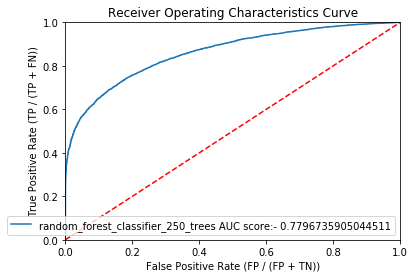

Time to train 300 trees:- 
64.47255492210388
Accuracy score for 300 trees:- 
0.7809099901088031
Confusion matrix for 300 trees:- 
[6867 1221 2323 5765]
OOB score for 300 trees:- 
0.7959544998746553
Classifier report for 300 trees:- 
              precision    recall  f1-score   support

         0.0       0.75      0.85      0.79      8088
         1.0       0.83      0.71      0.76      8088

   micro avg       0.78      0.78      0.78     16176
   macro avg       0.79      0.78      0.78     16176
weighted avg       0.79      0.78      0.78     16176



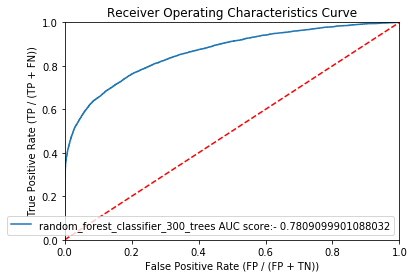

Time to train 400 trees:- 
99.3036150932312
Accuracy score for 400 trees:- 
0.7807245301681504
Confusion matrix for 400 trees:- 
[6875 1213 2334 5754]
OOB score for 400 trees:- 
0.7969102531962898
Classifier report for 400 trees:- 
              precision    recall  f1-score   support

         0.0       0.75      0.85      0.79      8088
         1.0       0.83      0.71      0.76      8088

   micro avg       0.78      0.78      0.78     16176
   macro avg       0.79      0.78      0.78     16176
weighted avg       0.79      0.78      0.78     16176



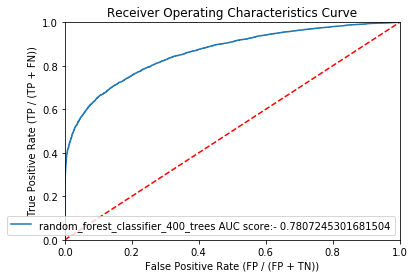

Time to train 500 trees:- 
103.58329439163208
Accuracy score for 500 trees:- 
0.7812809099901088
Confusion matrix for 500 trees:- 
[6861 1227 2311 5777]
OOB score for 500 trees:- 
0.7977093256455252
Classifier report for 500 trees:- 
              precision    recall  f1-score   support

         0.0       0.75      0.85      0.80      8088
         1.0       0.82      0.71      0.77      8088

   micro avg       0.78      0.78      0.78     16176
   macro avg       0.79      0.78      0.78     16176
weighted avg       0.79      0.78      0.78     16176



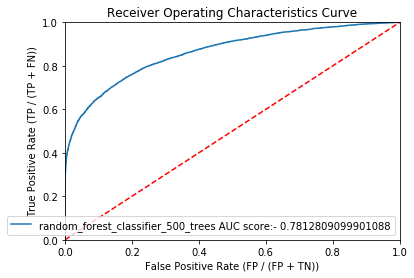

Time to train 750 trees:- 
181.6440770626068
Accuracy score for 750 trees:- 
0.7825791295746786
Confusion matrix for 750 trees:- 
[6882 1206 2311 5777]
OOB score for 750 trees:- 
0.7987747555778391
Classifier report for 750 trees:- 
              precision    recall  f1-score   support

         0.0       0.75      0.85      0.80      8088
         1.0       0.83      0.71      0.77      8088

   micro avg       0.78      0.78      0.78     16176
   macro avg       0.79      0.78      0.78     16176
weighted avg       0.79      0.78      0.78     16176



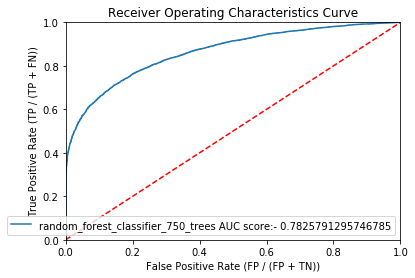

Time to train 1000 trees:- 
261.6922743320465
Accuracy score for 1000 trees:- 
0.7804154302670623
Confusion matrix for 1000 trees:- 
[6853 1235 2317 5771]
OOB score for 1000 trees:- 
0.7994171471546754
Classifier report for 1000 trees:- 
              precision    recall  f1-score   support

         0.0       0.75      0.85      0.79      8088
         1.0       0.82      0.71      0.76      8088

   micro avg       0.78      0.78      0.78     16176
   macro avg       0.79      0.78      0.78     16176
weighted avg       0.79      0.78      0.78     16176



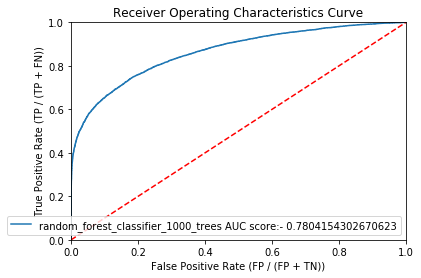

In [77]:
#Have to use Bayesian Optimization to find better set of hyperparameters
#best performance value found 400
no_of_trees = [10,20,30,40,50,100,150,200,250,300,400,500,750,1000]
error = []
for noft in no_of_trees:
    starttime = time.time()
    classifier = RandomForestClassifier(n_estimators=noft,max_depth=25,oob_score=True)
    classifier.fit(X_train,y_train)
    endtime = time.time()
    print("Time to train " + str(noft) + " trees:- ")
    print(endtime - starttime)
    error.append(classifier.oob_score_)
    prediction = classifier.predict(X_test)
    print("Accuracy score for " + str(noft) + " trees:- ")
    print(accuracy_score(y_test,prediction))
    print("Confusion matrix for " + str(noft) + " trees:- ")
    print(confusion_matrix(y_test,prediction).ravel())
    print("OOB score for " + str(noft) + " trees:- ")
    print(classifier.oob_score_)
    print("Classifier report for " + str(noft) + " trees:- ")
    generate_classifier_report(classifier,prediction,classifier.predict_proba(X_test)[:,1],"random_forest_classifier_" + str(noft) + "_trees")
    #get_rf_confidence_interval(classifier,prediction,"random_forest_classifier_" + str(noft) + "_trees")

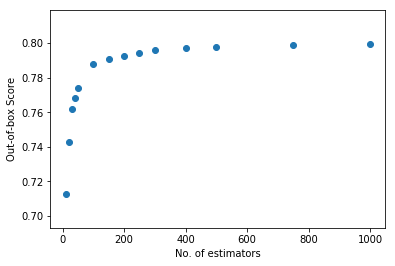

In [78]:
plt.scatter(no_of_trees,error)
plt.xlabel("No. of estimators")
plt.ylabel("Out-of-box Score")
plt.savefig("error_vs_nestimators.jpg")

In [79]:
def get_rf_confidence_interval(classifier,pred,name):
    plt.scatter(y_test, pred)
    plt.plot([5, 45], [5, 45], 'k--')
    plt.xlabel('Reported MPG')
    plt.ylabel('Predicted MPG')
    plt.axis((0,1,0,1))
    plt.show()
    var = forestci.random_forest_error(classifier, X_train,X_test)
    plt.errorbar(y_test, pred, yerr=np.sqrt(var), fmt='o')
    plt.plot([5, 45], [5, 45], 'k--')
    plt.xlabel('Reported MPG')
    plt.ylabel('Predicted MPG')
    plt.axis((0,1,0,1))
    plt.savefig(name + "_confidence_interval")
    plt.show()

In [81]:
starttime = time.time()
boosting = XGBClassifier(alpha=1,eval_metric='logloss',max_depth=25,n_estimators=400,verbosity=2)
boosting.fit(X_train,y_train)
endtime = time.time()
print("Time to train XGBClassifier :- ")
print(endtime - starttime)

Time to train XGBClassifier :- 
1307.2785658836365


In [82]:
pred = boosting.predict(X_test)
accuracy_score(y_test,pred)

0.7943249258160238

In [83]:
confusion_matrix(y_test,pred)

array([[6922, 1166],
       [2161, 5927]])

In [84]:
cross_validation_score(boosting,X,y,cv=5)

0.7776625

              precision    recall  f1-score   support

         0.0       0.76      0.86      0.81      8088
         1.0       0.84      0.73      0.78      8088

   micro avg       0.79      0.79      0.79     16176
   macro avg       0.80      0.79      0.79     16176
weighted avg       0.80      0.79      0.79     16176



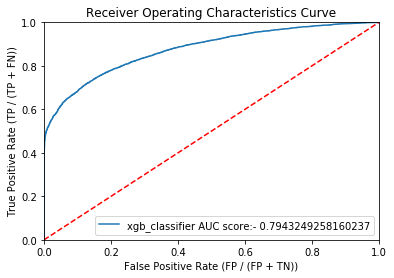

In [85]:
generate_classifier_report(boosting,pred,boosting.predict_proba(X_test)[:,1],'xgb_classifier')

In [86]:
starttime = time.time()
clf = lgb.LGBMClassifier(boosting_type='gbdt',objective='binary',n_estimators=400,max_depth=25)
clf.fit(X_train,y_train)
endtime = time.time()
print("Time to train LightGBM classifier:- ")
print(endtime - starttime)

Time to train LightGBM classifier:- 
30.509165048599243


In [87]:
pred = clf.predict(X_test)
accuracy_score(y_test,pred)

0.7992705242334323

In [88]:
confusion_matrix(y_test,pred)

array([[6991, 1097],
       [2150, 5938]])

In [89]:
cross_validation_score(clf,X_train,y_train,cv=5)

0.7727118826140005

              precision    recall  f1-score   support

         0.0       0.76      0.86      0.81      8088
         1.0       0.84      0.73      0.79      8088

   micro avg       0.80      0.80      0.80     16176
   macro avg       0.80      0.80      0.80     16176
weighted avg       0.80      0.80      0.80     16176



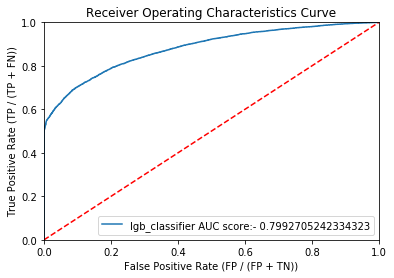

In [90]:
generate_classifier_report(clf,pred,clf.predict_proba(X_test)[:,1],'lgb_classifier')

In [91]:
X = tf.placeholder(shape=[None,222],dtype=tf.float32)
y = tf.placeholder(shape=[None],dtype=tf.int64)

In [92]:
weights = {
    'W1': tf.Variable(tf.truncated_normal(shape=[222,140])),
    'W2': tf.Variable(tf.truncated_normal(shape=[140,70])),
    'W3': tf.Variable(tf.truncated_normal(shape=[70,27])),
    'W4': tf.Variable(tf.truncated_normal(shape=[27,1]))
}
biases = {
    'b1': tf.Variable(tf.truncated_normal(shape=[140])),
    'b2': tf.Variable(tf.truncated_normal(shape=[70])),
    'b3': tf.Variable(tf.truncated_normal(shape=[27])),
    'b4': tf.Variable(tf.truncated_normal(shape=[1]))
}

In [93]:
def get_model(X,weights,biases):
    op1 = tf.add(tf.matmul(X,weights['W1']),biases['b1'])
    relu_op1 = tf.nn.relu(op1) 
    op2 = tf.add(tf.matmul(relu_op1,weights['W2']),biases['b2'])
    relu_op2 = tf.nn.relu(op2)
    op3 = tf.add(tf.matmul(relu_op2,weights['W3']),biases['b3'])
    relu_op3 = tf.nn.relu(op3)
    op4 = tf.add(tf.matmul(relu_op3,weights['W4']),biases['b4'])
    return op4

In [94]:
pred = get_model(X,weights,biases)
optimizer = tf.train.AdamOptimizer(learning_rate=0.)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=pred))
train_step = optimizer.minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [95]:
#Improve accuracy here 
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(0,10):
        cost = 0
        total_batch = X_train.shape[0]/100
        X_batches = np.array_split(X_train,total_batch)
        y_batches = np.array_split(y_train,total_batch)
        for j in range(0,int(total_batch)):
            g,c = sess.run([train_step,loss],feed_dict={
                X: X_batches[j],
                y: y_batches[j]
            })
            cost = cost + c/total_batch
        print("Epoch:- " + str(i) + " Cost:- " + str(cost))
    correct_prediction = tf.equal(tf.argmax(pred,1),y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,"float"))
    print("Accuracy:- " + str(accuracy.eval({X: X_test,y: y_test})))

Epoch:- 0 Cost:- 230.27163413749093
Epoch:- 1 Cost:- 230.27163413749093
Epoch:- 2 Cost:- 230.27163413749093
Epoch:- 3 Cost:- 230.27163413749093
Epoch:- 4 Cost:- 230.27163413749093
Epoch:- 5 Cost:- 230.27163413749093
Epoch:- 6 Cost:- 230.27163413749093
Epoch:- 7 Cost:- 230.27163413749093
Epoch:- 8 Cost:- 230.27163413749093
Epoch:- 9 Cost:- 230.27163413749093
Accuracy:- 0.5
